In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from copy import copy

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

lasso_methods = [
    "lasso1_nocluster", 
    "lasso1_rollingkmeans_k5_pca", "lasso1_rollingspectral_k5_pca",
    "lasso1_rollingkmeans_k5_rank", "lasso1_rollingspectral_k5_rank",
    "lasso1_rollingkmeans_k10_pca", "lasso1_rollingspectral_k10_pca",
    "lasso1_rollingkmeans_k10_rank", "lasso1_rollingspectral_k10_rank",
    "lasso1_rollingkmeans_kauto_eigen_rank", "lasso1_rollingspectral_kauto_eigen_rank"

]
varlingam_methods = [
    "var-lingam_rollingkmeans_k5_pca", "var-lingam_rollingspectral_k5_pca",
    "var-lingam_rollingkmeans_k5_rank", "var-lingam_rollingspectral_k5_rank",
    "var-lingam_rollingkmeans_k10_pca", "var-lingam_rollingspectral_k10_pca",
    "var-lingam_rollingkmeans_k10_rank", "var-lingam_rollingspectral_k10_rank",
    "var-lingam_rollingspectral_kauto_eigen_rank", "var-lingam_rollingkmeans_kauto_eigen_rank"
]
pairwisegranger_methods = [
    "pairwise-granger_rollingkmeans_k5_pca", "pairwise-granger_rollingspectral_k5_pca",
    "pairwise-granger_rollingkmeans_k5_rank", "pairwise-granger_rollingspectral_k5_rank",
    "pairwise-granger_rollingkmeans_k10_pca", "pairwise-granger_rollingspectral_k10_pca",
    "pairwise-granger_rollingkmeans_k10_rank", "pairwise-granger_rollingspectral_k10_rank",
    "pairwise-granger_rollingspectral_kauto_eigen_rank", "pairwise-granger_rollingkmeans_kauto_eigen_rank"
]
mulivariategranger_methods = [
    "multivariate-granger_rollingkmeans_k5_pca", "multivariate-granger_rollingspectral_k5_pca",
    "multivariate-granger_rollingkmeans_k5_rank", "multivariate-granger_rollingspectral_k5_rank",
    "multivariate-granger_rollingkmeans_k10_pca", "multivariate-granger_rollingspectral_k10_pca",
    "multivariate-granger_rollingkmeans_k10_rank", "multivariate-granger_rollingspectral_k10_rank",
    "multivariate-granger_rollingspectral_kauto_eigen_rank", "multivariate-granger_rollingkmeans_kauto_eigen_rank"
]
dynotears_methods = [
        "dynotears_rollingkmeans_k5_pca", "dynotears_rollingspectral_k5_pca", 
        "dynotears_rollingkmeans_k5_rank", "dynotears_rollingspectral_k5_rank",
        "dynotears_rollingkmeans_k10_pca", "dynotears_rollingspectral_k10_pca", 
        "dynotears_rollingkmeans_k10_rank", "dynotears_rollingspectral_k10_rank",
        "dynotears_rollingspectral_kauto_eigen_rank",
]

fs_methods = [
        "sfstscv_nocluster",
        "dynotears_nocluster"
]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [4]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if "nocluster" in fs:
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
        elif ("pca" in fs):
            codes, uniques = pd.factorize(parents_of_target_df['fred'])
            parents_of_target_df['cluster'] = codes         
        else:
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

## Parents over time

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

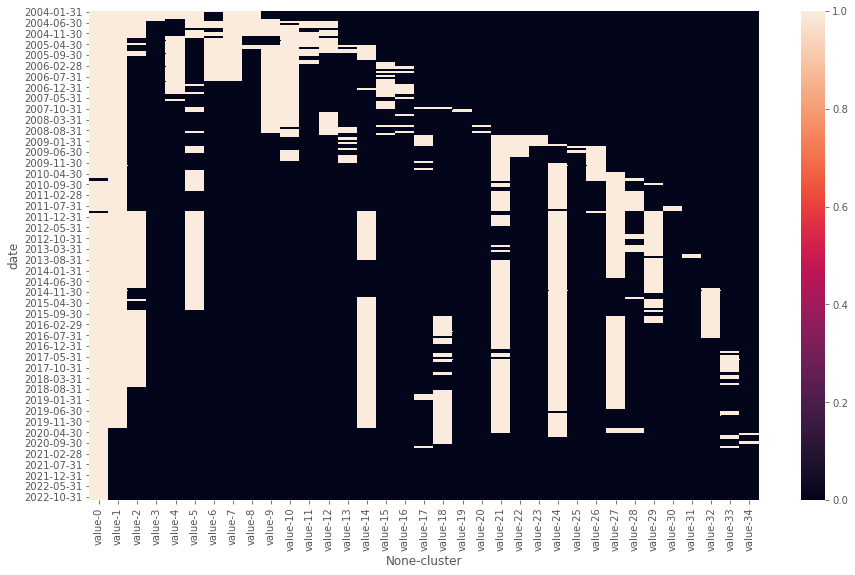

In [5]:
etf = "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(15, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

<AxesSubplot:xlabel='None-cluster', ylabel='date'>

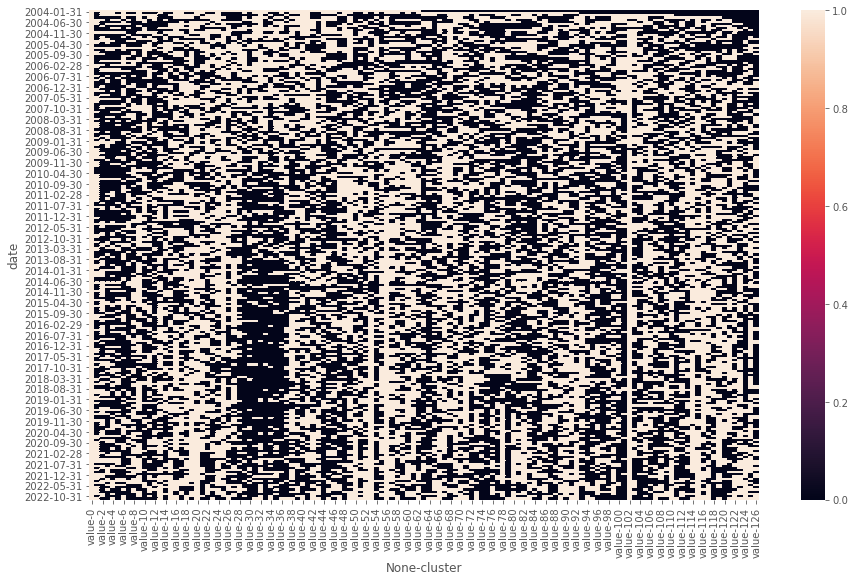

In [6]:
etf = "SPY"
fs = "sfstscv_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(15, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

## Average Number of Parents

In [7]:
avgs = []
for fs in all_parents_df["fs"].unique():
    for etf in all_parents_df["etf"].unique():
        check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

        mean = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).mean()
        std = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).std()
        skew = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).sum(axis=1).skew()

        avgs.append({"fs": fs, "etf": etf,
                     "mean": mean if not pd.isna(mean) else 0,
                     "std": std if not pd.isna(std) else 0,
                     "skew": skew if not pd.isna(skew) else 0})
avgs_df = pd.DataFrame(avgs)

In [8]:
avgs_df.sort_values(by=["mean"], ascending=False)[["fs", "etf", "mean", "std"]]

,fs,etf,mean,std
0,sfstscv_nocluster,XLE,63.000000,0.000000
2,sfstscv_nocluster,XLF,63.000000,0.000000
3,sfstscv_nocluster,SPY,63.000000,0.000000
4,sfstscv_nocluster,XLY,63.000000,0.000000
5,sfstscv_nocluster,XLU,63.000000,0.000000
6,sfstscv_nocluster,XLB,63.000000,0.000000
7,sfstscv_nocluster,XLV,63.000000,0.000000
8,sfstscv_nocluster,XLP,63.000000,0.000000
9,sfstscv_nocluster,XLI,63.000000,0.000000
1,sfstscv_nocluster,XLK,63.000000,0.000000


## New Stability measure

In [9]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

### (a) Stability Measure over time

<AxesSubplot:xlabel='date'>

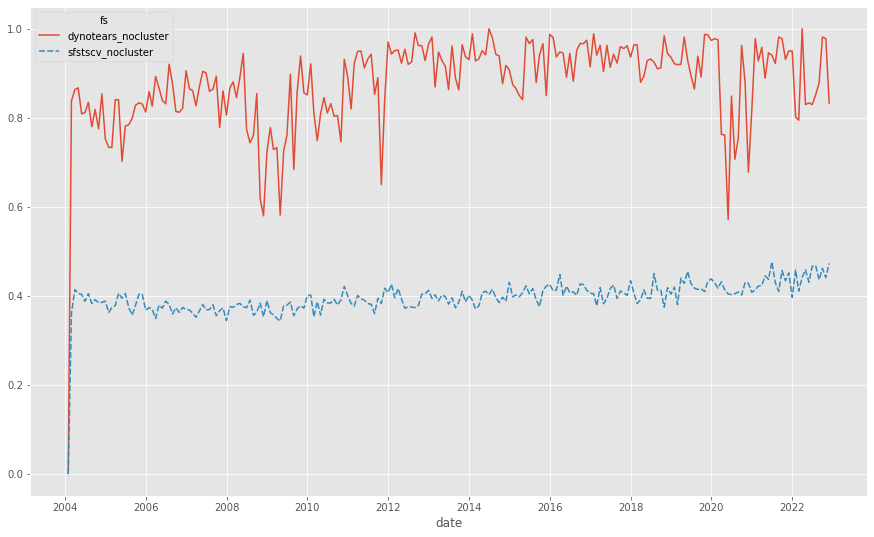

In [10]:
pivot_all_etfs_scores_df = all_etfs_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)

plt.figure(figsize=(15, 9))
sns.lineplot(data=pivot_all_etfs_scores_df)

<AxesSubplot:xlabel='date'>

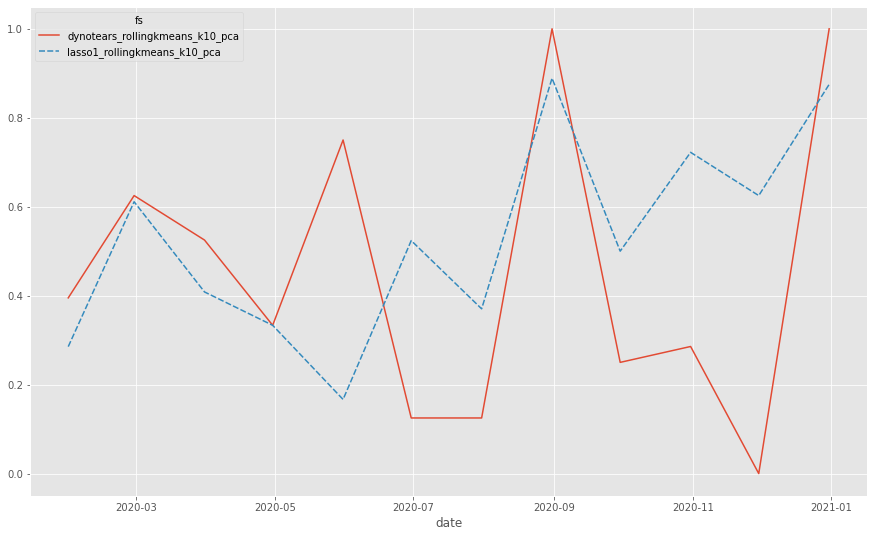

In [24]:
selected_models = [
    "dynotears_rollingkmeans_k10_pca",
    "lasso1_rollingkmeans_k10_pca",
]

pivot_all_etfs_scores_df = all_etfs_scores_df.loc[all_etfs_scores_df["fs"].isin(selected_models)].pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)

plt.figure(figsize=(15, 9))
sns.lineplot(data=pivot_all_etfs_scores_df.loc["2020-01-01":"2020-12-31"])

In [23]:
pivot_all_etfs_scores_df.corr()

fs,dynotears_rollingkmeans_k10_pca,lasso1_rollingkmeans_k10_pca
fs,,
dynotears_rollingkmeans_k10_pca,1.000000,0.668741
lasso1_rollingkmeans_k10_pca,0.668741,1.000000


### (b) Average Stability Measure

In [63]:
avg_scores_df = all_etfs_scores_df.drop(["date"], axis=1).groupby(["etf", "fs"]).mean().sort_values(by=["value"], ascending=False)

avg_scores_df.head(20)

,,value
etf,fs,
XLY,lasso2_nocluster,0.973837
XLK,var-lingam_rollingspectral_k5_pca,0.973684
XLE,lasso2_nocluster,0.970183
XLI,lasso2_nocluster,0.965969
XLV,lasso2_nocluster,0.962555
XLU,var-lingam_rollingspectral_k5_rank,0.954545
XLF,lasso2_nocluster,0.952532
XLP,var-lingam_rollingkmeans_k5_rank,0.952381
XLK,var-lingam_rollingspectral_k5_rank,0.951691


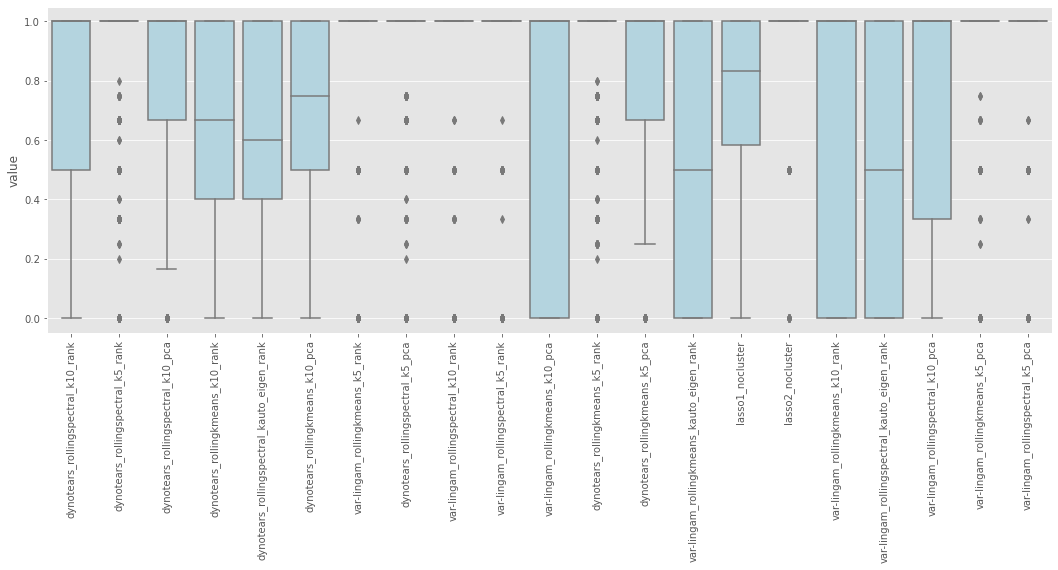

In [64]:
avg_scores_df.reset_index()

# box plot with "fs" column on the x-axis and "value" column on the y-axis
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="fs", y="value", data=all_etfs_scores_df, color="lightblue", ax=ax)
ax.set_xlabel("", fontsize=20)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
plt.xticks(rotation=90)
plt.show()